# DCGAN with Cifar10 Data

In [1]:
import tensorflow as tf

In [2]:
# We install imageio to make GIFs
!pip install imageio

In [3]:
# The glob module finds all the pathnames matching a specified pattern according to the rules used
import glob
# imageio is a Python library that provides an easy interface to read and write a wide range of image data,
import imageio

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

# PIL is Python Imaging Library which is a free and open-source additional library for the Python programming language 
# that adds support for opening, manipulating, and saving many different image file formats.
import PIL
from PIL import Image
from tensorflow.keras import datasets, layers, models
import time
import random
%load_ext tensorboard
from IPython import display

%matplotlib inline

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 6s 0us/step


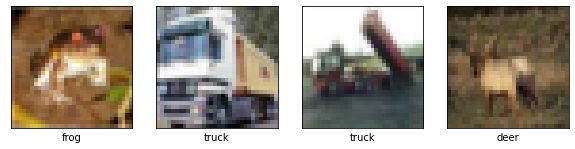

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 120000
BATCH_SIZE = 256

In [8]:
# Create batches of data and shuffle them.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Creating the model
Generator and Discriminator are defined using [Keras Sequential API] 


In [9]:
# Let's make genrator model function

def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU())


    model.add(layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256) 


    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', 
                                     use_bias=False, activation='tanh')) 
    assert model.output_shape == (None, 32, 32, 3) 

    return model

Let's create an image using a generator that hasn't been trained yet.

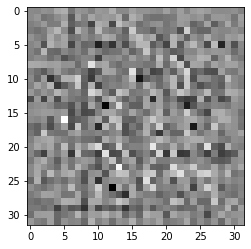

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Flatten())
 
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00038649]], shape=(1, 1), dtype=float32)


In [13]:
# This method returns a helper function to compute the cross entropy loss. (for Binary Classification)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
# Use Adam as the Optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoint
This notebook shows you how to save and restore models that can be useful in cases where long-running training is disrupted.

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Experiment utils (RUN ME!)

In [18]:
# Define the training loop

EPOCHS = 10000
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Model Traning

In [20]:
# Create and save images

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [21]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

# Instantly create images for GIF.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)


# It saves the model every 15 epoch passes
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    

 # print the report on how much time it takes for each epoch
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Generate after the last epoch is over.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


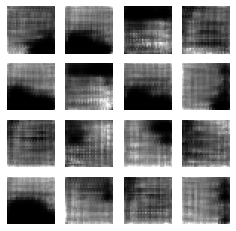

CPU times: user 11h 5min 18s, sys: 1h 33min 42s, total: 12h 39min
Wall time: 11h 15min 12s


In [22]:
# # Model training
%%time
train(train_dataset, EPOCHS)

In [23]:
# Restore the last checkpoint.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [24]:
# Create GIF
# Displays a single image using epoch numbers.

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

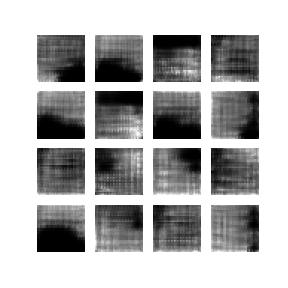

In [25]:
display_image(EPOCHS)

In [26]:
# Create a GIF animation using images saved during training with imageio.

anim_file = 'dcganwithcifar10.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [27]:
# If you are working at Colab, you can download the animation from the code below:

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>